# Deep Feed-forward Networks

Feed-forward neural network on the dataset called "Fashion MNIST"

In [1]:
#@title Imports (RUN ME!) { display-mode: "form" }
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

try:
  tf.enable_eager_execution()
  print('Running in Eager mode.')
except ValueError:
  print('Already running Eagerly')

Running in Eager mode.


In [2]:
# Loading fashion_mnist using tensorflow
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_and_validation_images, train_and_validation_labels), (test_images, test_labels) = fashion_mnist.load_data()

text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
# Construct a validation set from the last 10000 images and labels from 
# train_and_validation_images and train_and_validation_labels
validation_images = train_and_validation_images[-10000:, :, :]
validation_labels = train_and_validation_labels[-10000:]

# Construct a training set from the first 50000 images and labels.
train_images = train_and_validation_images[:50000, :, :]
train_labels = train_and_validation_labels[:50000]

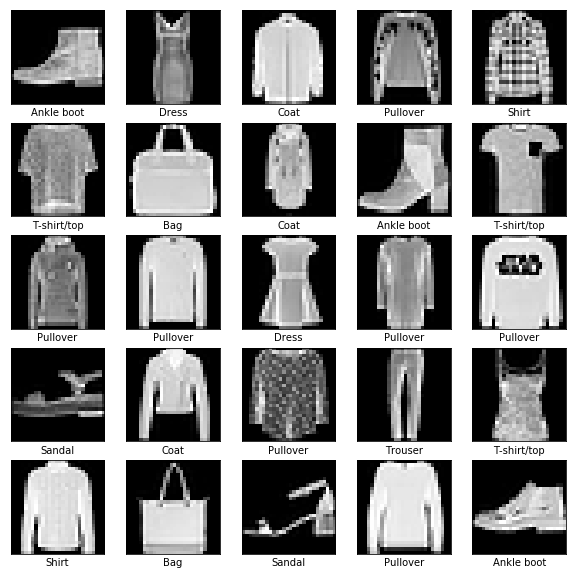

In [8]:
# Plot showing 25 randomly selected images at a time
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap=plt.cm.gray)
    plt.xlabel(text_labels[train_labels[img_index]])

In [9]:
batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

# Rescaling pixel values so that they end up as a floating point number between 0 and 1
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32))) 
# Shuffle the examples.
train_ds = train_ds.shuffle(buffer_size=batch_size * 10) 
# Now "chunk" the examples into batches
train_ds = train_ds.batch(batch_size) 

In [10]:
model = tf.keras.Sequential([
    # Convert the 28x28 image into a flat vector of 28x28 = 784 values
    tf.keras.layers.Flatten(input_shape=(28, 28), name='flatten_input'),  
    # Create a "hidden" layer with 256 neurons and apply the ReLU non-linearity
    tf.keras.layers.Dense(256, activation=tf.nn.relu, name='input_to_hidden1'),  
    # Create another hidden layer with 128 neurons
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden1_to_hidden2'),
    # Create an "output layer" with 10 neurons
    tf.keras.layers.Dense(10, name='hidden_to_logits'),  
])

In [11]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (Flatten)      (None, 784)               0         
_________________________________________________________________
input_to_hidden1 (Dense)     (None, 256)               200960    
_________________________________________________________________
hidden1_to_hidden2 (Dense)   (None, 128)               32896     
_________________________________________________________________
hidden_to_logits (Dense)     (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


Epoch 000: Loss: 0.535, Accuracy: 81.330%
Epoch 001: Loss: 0.376, Accuracy: 86.530%
Epoch 002: Loss: 0.337, Accuracy: 87.566%
Epoch 003: Loss: 0.310, Accuracy: 88.550%
Epoch 004: Loss: 0.290, Accuracy: 89.316%
Epoch 005: Loss: 0.273, Accuracy: 90.050%
Epoch 006: Loss: 0.258, Accuracy: 90.350%
Epoch 007: Loss: 0.248, Accuracy: 90.862%
Epoch 008: Loss: 0.234, Accuracy: 91.322%
Epoch 009: Loss: 0.225, Accuracy: 91.592%
Epoch 010: Loss: 0.217, Accuracy: 91.894%
Epoch 011: Loss: 0.207, Accuracy: 92.330%
Epoch 012: Loss: 0.200, Accuracy: 92.406%
Epoch 013: Loss: 0.194, Accuracy: 92.712%
Epoch 014: Loss: 0.183, Accuracy: 93.116%
Epoch 015: Loss: 0.174, Accuracy: 93.468%
Epoch 016: Loss: 0.172, Accuracy: 93.460%
Epoch 017: Loss: 0.165, Accuracy: 93.752%
Epoch 018: Loss: 0.158, Accuracy: 94.020%
Epoch 019: Loss: 0.155, Accuracy: 94.162%
Epoch 020: Loss: 0.149, Accuracy: 94.414%
Epoch 021: Loss: 0.139, Accuracy: 94.684%
Epoch 022: Loss: 0.137, Accuracy: 94.900%
Epoch 023: Loss: 0.129, Accuracy: 

Text(0.5, 1.0, 'Accuracy vs epochs')

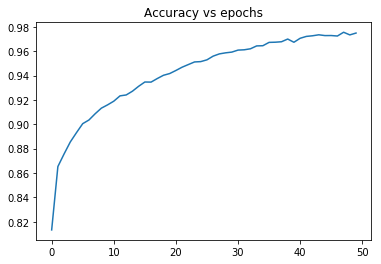

In [12]:
# Create an optimizer
# The optimizer is responsible for controlling the learning rate
optimizer = tf.train.AdamOptimizer()

step_counter = tf.train.get_or_create_global_step()  # Just a variable that keeps track of how many training steps we've run
num_epochs = 50  # The number of epochs to run

# Lists to store the loss and accuracy of every epoch
epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
  # Tensorflow provides a convenient API for tracking a number of metrics during training/evaluation
  loss_avg = tfe.metrics.Mean()
  accuracy = tfe.metrics.Accuracy()

  # Loop over our data pipeline
  for step, (image_batch, label_batch) in enumerate(train_ds):
    
    # Initialise a GradientTape to track the operations
    with tf.GradientTape() as tape:
      # Compute the logits (un-normalised scores) of the current batch of examples 
      # using the neural network architecture we defined earlier
      logits = model(image_batch, training=True)
      # Compute the cross-entropy loss of the classification outputs on this batch
      loss_value = tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=logits, labels=label_batch)  
      # Compute the average loss over the batch
      loss_value = tf.reduce_mean(loss_value)  
      
      # Add current batch loss to our loss metric tracker - note the function call semantics
      loss_avg(loss_value)  
      # Compare most likely predicted label to actual label
      accuracy(tf.argmax(logits, axis=1, output_type=tf.int32), label_batch)

    # Play the tape backwards and get the gradient of the loss of the current batch
    # Note we're now outside the scope of the with-block above
    grads = tape.gradient(loss_value, model.variables)
    # Use the optimizer to apply the gradients to the model parameters along with
    # its internal learning rate
    optimizer.apply_gradients(
        zip(grads, model.variables), global_step=step_counter)
  
  # Get the average loss and accuracy for the epoch
  epoch_loss = loss_avg.result()
  epoch_losses.append(epoch_loss)
  epoch_accuracy = accuracy.result()
  epoch_accuracies.append(epoch_accuracy)
  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, epoch_loss, epoch_accuracy))
  
# Plot the loss for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), epoch_losses)
plt.title('Loss vs epochs')

# Plot the accuracy for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), epoch_accuracies)
plt.title('Accuracy vs epochs')

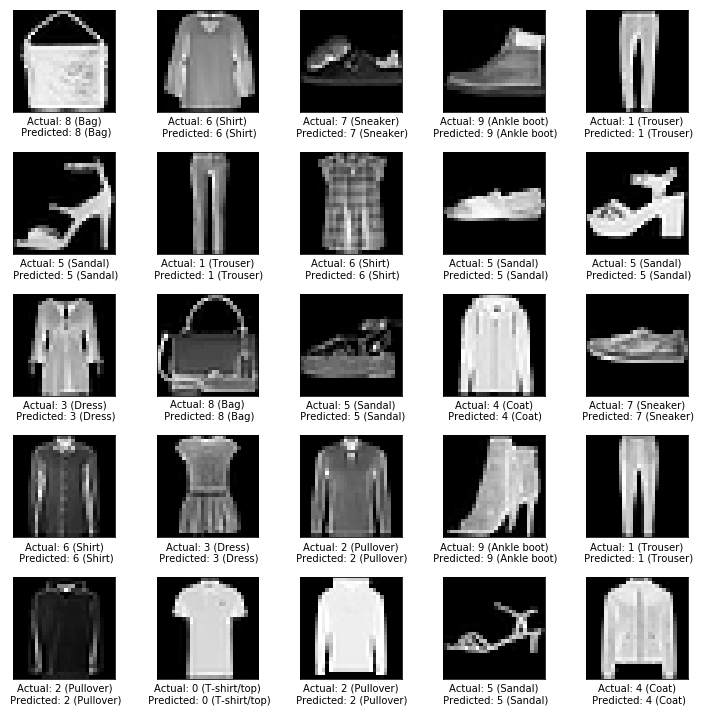

In [13]:
images, labels = next(train_ds.make_one_shot_iterator())  # Get a batch of images and labels

_logits = model(images, training=False)  # Pass the images to the model function and get its output logits
predicted_labels = tf.argmax(_logits, axis=1, output_type=tf.int32)

img_indexs = np.arange(images.numpy().shape[0])
np.random.shuffle(img_indexs)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    
    img_index = img_indexs[i]
    predicted_label = int(predicted_labels[img_index])
    
    plt.imshow(images[img_index], cmap=plt.cm.gray)
    
    actual_label = int(labels[img_index].numpy())
    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
    ))
    
plt.tight_layout()
plt.show()